In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential, load_modelad_
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Activation

from skimage import io, transform, exposure

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime
import os

# Load CSVs Tran and Test

In [5]:
df_Train = pd.read_csv("../dataset/archive/Train.csv")[["ClassId", "Path"]]
df_Test = pd.read_csv("../dataset/archive/Test.csv")[["ClassId", "Path"]]

In [6]:
df_Train

ClassId                            Path
0           20  Train/20/00020_00000_00000.png
1           20  Train/20/00020_00000_00001.png
2           20  Train/20/00020_00000_00002.png
3           20  Train/20/00020_00000_00003.png
4           20  Train/20/00020_00000_00004.png
...        ...                             ...
39204       42  Train/42/00042_00007_00025.png
39205       42  Train/42/00042_00007_00026.png
39206       42  Train/42/00042_00007_00027.png
39207       42  Train/42/00042_00007_00028.png
39208       42  Train/42/00042_00007_00029.png

[39209 rows x 2 columns]

In [7]:
total = df_Train.shape[0]+df_Test.shape[0]
print(f"Train Size: {df_Train.shape[0]} images ({df_Train.shape[0]/ total*100})")
print(f"Test Size: {df_Test.shape[0]} images ({df_Test.shape[0]/ total*100})")

Train Size: 39209 images (75.63610409151411)
Test Size: 12630 images (24.363895908485887)


# Function to Load Images 

In [8]:
# This function first shuffle the dataset, after load the image to memory, resize it, equelize the contrast and finally save to an array.
def load_images(main_path, df):
    data = []
    
    # SHUFFLE DATA FRAME
    df_shuffle = df.sample(frac=1)
    
    for (i, image_path) in enumerate(df):
        if i > 0 and i % 1000 == 0:
            print(f"[DEBUG] Total processed images: {i}")
            
        image_full_path = os.path.sep.join([main_path, image_path])
        image = io.imread(image_full_path)

        image = transform.resize(image, (32,32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)

        data.append(image)
            
    data = np.array(data)
    return data

# Model Function

In [9]:
def build(width, height, depth, classes, conv_size, dense_size, filter_size):
        model = Sequential()

        inputShape = (height, width, depth)
        dim = 1

        model.add(Conv2D(filter_size[0], conv_size[0], padding = "same", input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Conv2D(filter_size[1], conv_size[1], padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(Conv2D(filter_size[1], conv_size[1], padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Conv2D(filter_size[2], conv_size[2], padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(Conv2D(filter_size[2], conv_size[2], padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=dim))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Flatten())
        model.add(Dense(dense_size[0]))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(dense_size[1]))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [14]:
def saveModel(model, path):
    # GETTING THE CURRENT TIME
    now = datetime.now()
    date = now.strftime("%d_%m_%Y_%H_%M_%S")
    
    # SAVING MODEL
    model_path = path + date
    print(f"[INFO] serialiazing network to {model_path}")
    model.save(model_path)

In [53]:
def printPrediction(model, Y_Test, prediction, label_names, file_name):
    pred = classification_report(Y_Test.argmax(axis=1), prediction.argmax(axis=1), target_names = label_names, output_dict=True)
#     print(pred)
    
    df_pred = pd.DataFrame(pred).transpose()
    df_pred.to_csv(file_name)


In [58]:
def savePlotMetrics(num_epochs, hist, path, title):
    N = np.arange(0, num_epochs)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, hist.history["loss"], label="train_loss")
    plt.plot(N, hist.history["val_loss"], label="val_loss")
    plt.plot(N, hist.history["accuracy"], label="train_acc")
    plt.plot(N, hist.history["val_accuracy"], label="val_acc")
    plt.title(f"Training Loss and Accuracy on Database - {title}.")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig(path)

In [75]:
def saveHist(hist, file_name):
    df_hist = pd.DataFrame(hist.history)
    df_hist.to_csv(file_name)

In [ ]:
def run():
    NUM_EPOCHS = 30
    INIT_LR = 0.001
    BS = 64

    print(f"[DEBUG] Loading dataset ...\n")
    df_Train = pd.read_csv("../dataset/archive/Train.csv")[["ClassId", "Path"]]
    df_Test = pd.read_csv("../dataset/archive/Test.csv")[["ClassId", "Path"]]
    label_names = pd.read_csv("../dataset/archive/signnames.csv")["SignName"]

    print(f"[DEBUG] Load images from file and prepare data ...\n")
    X_Train = load_images("../dataset/archive", df_Train["Path"])
    X_Test = load_images("../dataset/archive", df_Test["Path"])

    # GET THE TOTAL UNIQUE TRANSIT SIGN
    num_labels = df_Train["ClassId"].unique().size

    # GET THE Y CLASS
    Y_Train = np.array(df_Train["ClassId"])
    Y_Test = np.array(df_Test["ClassId"])

    # NORMALIZE THE RGB PIXELS VALUES
    X_Train = X_Train.astype("float32") / 255.0
    X_Test  = X_Test.astype("float32") / 255.0

    # ONE HOT ENCODING
    Y_Train = to_categorical(Y_Train, num_labels)
    Y_Test = to_categorical(Y_Test, num_labels)  

    # CREATE A DICTIONARY BY CLASS AND CALC THE WEIGHT, THIS BECAUSE THE DATASET IS NOT HOMOGENEOUS
    # GET THE TOTAL TRANSIT SIGN IMAGES
    total_classes = Y_Train.sum(axis=0)
    class_weight = dict()

    # CALCULATE THE CLASS WEIGHT
    for i in range(0, len(total_classes)):
        class_weight[i] = total_classes.max() / total_classes[i]


    conv_size   = [[(2,2), (3,3), (3,3)], [(3,3), (3,3), (3,3)] , [(5,5), (3,3), (3,3)], [(5,5), (5,5), (5,5)], [(5,5), (8,8), (4,4)]]
    dense_size  = [[64, 64], [64, 128], [128, 256], [256, 256], [256, 512]]
    filter_size = [[4,4,8], [4,8,16], [8,16,32], [16,32,64], [32,32,64]]

    for conv in conv_size:
        for dense in dense_size:
            for filter_ in filter_size:

                # IMAGE GENERATOR
                img_gen = ImageDataGenerator(rotation_range = 10,
                                             zoom_range = 0.15,
                                             width_shift_range = 0.1,
                                             height_shift_range = 0.1,
                                             shear_range = 0.15,
                                             horizontal_flip = False,
                                             vertical_flip = False,
                                             fill_mode = "nearest")

                print(f"[DEBUG] Config Model ...\n")
                # ADAM OPTIMIZER
                opt = Adam(learning_rate=INIT_LR, decay = INIT_LR / (NUM_EPOCHS * 0.5))                

                # CNN
                model = build(width = 32, height = 32, depth = 3, classes = num_labels, conv_size = conv, dense_size = dense, filter_size = filter_)
                model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

                print(f"[DEBUG] Training ...\n")

                hist = model.fit(img_gen.flow(X_Train, Y_Train, batch_size = BS),
                                validation_data = (X_Test, Y_Test), 
                                steps_per_epoch = X_Train.shape[0] // BS,
                                epochs = NUM_EPOCHS,
                                class_weight = class_weight,
                                verbose = 1)

                print(f"[DEBUG] Evaluating ...\n")
                prediction = model.predict(X_Test, batch_size = BS)

                conv_name = f"_Conv_{conv[0][0]}x{conv[0][1]}_{conv[1][0]}x{conv[1][1]}_{conv[2][0]}x{conv[2][1]}"
                dense_name = f"_Dense_{dense[0]}_{dense[1]}"
                filter_name = f"_Filter_{filter_[0]}_{filter_[1]}_{filter_[2]}"

                model_name = conv_name+dense_name+filter_name

                print(f"[DEBUG] Saving Prediction ...\n")
                printPrediction(model, Y_Test, prediction, label_names, f"../plots/pred_{model_name}.csv")
                print(f"[DEBUG] Saving Model ...\n")
                saveModel(model, f"../models/sign_model_{model_name}.h5")
                print(f"[DEBUG] Saving plot ...\n")        
                savePlotMetrics(NUM_EPOCHS, hist, f"../plots/plot_{model_name}.png", model_name)
                print(f"[DEBUG] Saving hist ...\n")          
                saveHist(hist,f"../hists/hist_{model_name}.csv")

    
    

[DEBUG] Config Model ...

[DEBUG] Training ...

Epoch 1/2
612/612 [==============================] - 44s 70ms/step - loss: 8.8956 - accuracy: 0.0983 - val_loss: 15.5300 - val_accuracy: 0.0285
Epoch 2/2
612/612 [==============================] - 53s 86ms/step - loss: 6.9451 - accuracy: 0.1769 - val_loss: 2.8855 - val_accuracy: 0.1857
[DEBUG] Evaluating ...

[DEBUG] Saving Prediction ...

{'Speed limit (20km/h)': {'precision': 0.09090909090909091, 'recall': 0.08333333333333333, 'f1-score': 0.08695652173913043, 'support': 60}, 'Speed limit (30km/h)': {'precision': 0.453125, 'recall': 0.12083333333333333, 'f1-score': 0.19078947368421054, 'support': 720}, 'Speed limit (50km/h)': {'precision': 0.30357142857142855, 'recall': 0.04533333333333334, 'f1-score': 0.07888631090487239, 'support': 750}, 'Speed limit (60km/h)': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 450}, 'Speed limit (70km/h)': {'precision': 0.23076923076923078, 'recall': 0.045454545454545456, 'f1-score': 0.0759

/Users/ivastival/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO:tensorflow:Assets written to: ../models/sign_model__Conv_5x5_3x3_3x3_Dense_128_128_Filter_8_16_32.h502_09_2021_11_37_39/assets
[DEBUG] Saving plot ...

[DEBUG] Saving hist ...

[DEBUG] Config Model ...

[DEBUG] Training ...

Epoch 1/2
612/612 [==============================] - 60s 95ms/step - loss: 9.0998 - accuracy: 0.0838 - val_loss: 25.0167 - val_accuracy: 0.0278
Epoch 2/2
612/612 [==============================] - 65s 106ms/step - loss: 6.8114 - accuracy: 0.1925 - val_loss: 2.0585 - val_accuracy: 0.3915
[DEBUG] Evaluating ...

[DEBUG] Saving Prediction ...

{'Speed limit (20km/h)': {'precision': 0.1111111111111111, 'recall': 0.08333333333333333, 'f1-score': 0.09523809523809525, 'support': 60}, 'Speed limit (30km/h)': {'precision': 0.6175637393767706, 'recall': 0.30277777777777776, 'f1-score': 0.4063373718546132, 'support': 720}, 'Speed limit (50km/h)': {'precision': 0.5294117647058824, 'recall': 0.036, 'f1-score': 0.06741573033707864, 'support': 750}, 'Speed limit (60km/h)': {

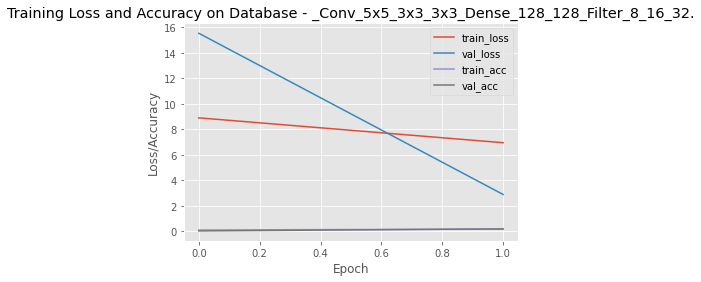

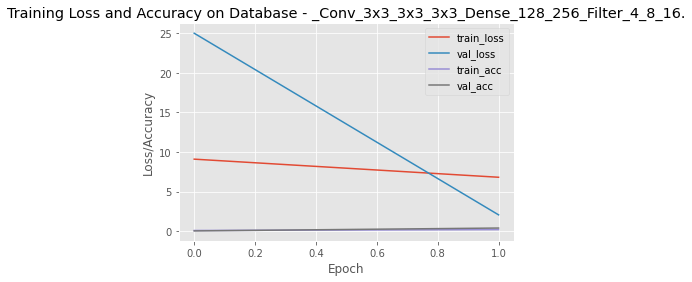

In [76]:
for i in range(0,len(conv_size)):

    # IMAGE GENERATOR
    img_gen = ImageDataGenerator(rotation_range = 10,
                                 zoom_range = 0.15,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 shear_range = 0.15,
                                 horizontal_flip = False,
                                 vertical_flip = False,
                                 fill_mode = "nearest")

    print(f"[DEBUG] Config Model ...\n")
    # ADAM OPTIMIZER
    opt = Adam(learning_rate=INIT_LR, decay = INIT_LR / (NUM_EPOCHS * 0.5))                

    # CNN
    model = build(width = 32, height = 32, depth = 3, classes = num_labels, conv_size = conv, dense_size = dense, filter_size = filter_)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])

    print(f"[DEBUG] Training ...\n")

    hist = model.fit(img_gen.flow(X_Train, Y_Train, batch_size = BS),
                    validation_data = (X_Test, Y_Test), 
                    steps_per_epoch = X_Train.shape[0] // BS,
                    epochs = NUM_EPOCHS,
                    class_weight = class_weight,
                    verbose = 1)

    print(f"[DEBUG] Evaluating ...\n")
    prediction = model.predict(X_Test, batch_size = BS)

    conv_name = f"_Conv_{conv_size[i][0][0]}x{conv_size[i][0][1]}_{conv_size[i][1][0]}x{conv_size[i][1][1]}_{conv_size[i][2][0]}x{conv_size[i][2][1]}"
    dense_name = f"_Dense_{dense_size[i][0]}_{dense_size[i][1]}"
    filter_name = f"_Filter_{filter_size[i][0]}_{filter_size[i][1]}_{filter_size[i][2]}"

    model_name = conv_name+dense_name+filter_name
    
    print(f"[DEBUG] Saving Prediction ...\n")
    printPrediction(model, Y_Test, prediction, label_names, f"../plots/pred_{model_name}.csv")
    print(f"[DEBUG] Saving Model ...\n")
    saveModel(model, f"../models/sign_model_{model_name}.h5")
    print(f"[DEBUG] Saving plot ...\n")        
    savePlotMetrics(NUM_EPOCHS, hist, f"../plots/plot_{model_name}.png", model_name)
    print(f"[DEBUG] Saving hist ...\n")          
    saveHist(hist,f"../hists/hist_{model_name}.csv")




    
    

In [63]:
# run()